Weak lensing calculation tests
------------------------------

This notebook shows some weak lensing tests: how the reduced shear can be obtained from
measuring background galaxy ellipticities.

In [1]:
%matplotlib inline
import grale.lenses as lenses
import grale.cosmology as cosmology
import grale.plotutil as plotutil
import grale.feedback as feedback
from grale.constants import *
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA

V = lambda x,y: np.array([x,y], dtype=np.double)
cosm = cosmology.Cosmology(0.7, 0.27, 0, 0.73)
D = cosm.getAngularDiameterDistance

feedback.setDefaultFeedback("none")

We'll work with a lens model that I've used for strong lensing tests, just to have some
model to work with.

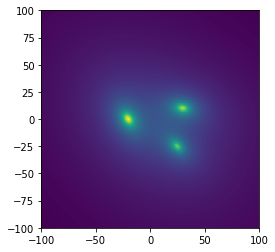

In [2]:
z_lens = 0.4
lens = lenses.GravitationalLens.load("reallens_nosheet.lensdata")
Dd = D(z_lens)
Dd, lens.getLensDistance()
li = plotutil.LensInfo(lens, size=200*ANGLE_ARCSEC, zd=z_lens, cosmology=cosm)
plotutil.plotDensity(li, angularUnit=ANGLE_ARCSEC);

A linear approximation of the lens equation

$$ \vec{\beta}(\vec{\theta}) = \vec{\theta} - \vec{\alpha}(\vec{\theta})$$

around a certain $\vec{\theta}$ and corresponding $\vec{\beta}(\vec{\theta})$ can be written in
matrix form as

$$\left(\begin{array}{c} \Delta\beta_x \\ \Delta\beta_y \end{array} \right) 
\left(\begin{array}{cc} 1-\kappa-\gamma_1 & -\gamma_2 \\ -\gamma_2 & 1-\kappa+\gamma_1 \end{array} \right) 
\left(\begin{array}{c} \Delta\theta_x \\ \Delta\theta_y \end{array} \right) 
$$
This matrix has eigenvalues $1-\kappa-\gamma$ and $1-\kappa+\gamma$, where $\gamma = \sqrt{\gamma_1^2 + \gamma_2^2}$, and corresponding eigenvectors $(\gamma_2, \gamma-\gamma_1)$ and $(\gamma_1-\gamma, \gamma_2)$ respectively. Calling $\phi$ the angle between the line through the the first eigenvector and the $x$ axis, one finds
$$ \gamma_1 = \gamma\cos(2\phi)$$
$$ \gamma_2 = \gamma\sin(2\phi)$$

In a first test, we'll work with a circular source, which will be transformed into an ellipse because of the
transformation above (which is from image plane to source plane, so actually using the inverse transformation). From image plane to source plane, along the axes of the eigenvectors (which are orthogonal), the shape is scaled by $1-\kappa+\gamma$ and $1-\kappa-\gamma$. 

If we go from source plane to lens plane, the eigenvectors will be the same, but the scaling will be the inverse. So a circular source of radius $R$ will be transformed into an ellipse with axes $a = \frac{R}{1-\kappa-\gamma}$ and $b = \frac{R}{1-\kappa+\gamma}$. The ratio of the two is

$$\frac{b}{a} = \frac{1-\kappa-\gamma}{1-\kappa+\gamma} = \frac{1-g}{1+g}$$

where the reduced shear

$$g = \frac{\gamma}{1-\kappa}$$

was introduced. This can be rearranged to get the reduced shear from the axes of the ellipse:

$$g = \frac{1-\frac{b}{a}}{1+\frac{b}{a}}$$

The angle $\phi$ can be derived from the angle that the ellipse makes with the $x$-axis. For a list of vectors, assumed to describe an elliptical shape, the function `estimageAngleAndAxes`below returns this angle, together with the lengths of the long and short axes.

When estimating $a$ and $b$ in this way, the resulting quantities will be positive. Note that when stating that e.g.  $a = \frac{R}{1-\kappa-\gamma}$, it's possible that this value will actually be negative, and so will differ from the value estimated from the shape. Even worse, based on the eigenvalues themselves, it's not necessarily the case that $1-\kappa-\gamma$ has the smallest absolute value, which would mean that the roles of $a$ and $b$ are actually reversed. These considerations lead to the possibility that for measured (positive) values of $a$ and $b$, where $a > b$, that the correct estimate of $g$ would be the inverse of the formula above:

$$g = \frac{1+\frac{b}{a}}{1-\frac{b}{a}}$$

Of course, solely based on the observed shape of the ellipse, there's no way to know which is actually correct. If we're assuming to be in the weak-lensing regime, where the mass density $\kappa$ is small and shear is small, then the first formula will be the one to use.

In [3]:
def estimateAngleAndAxes(thetas):
    center = np.mean(thetas, axis=0)
    dist = np.sum((thetas-center)**2,1)**0.5
    
    longIdx = np.argmax(dist)
    shortIdx = np.argmin(dist)

    dthetas = thetas-center
    angle = np.arctan2(dthetas[longIdx][1], dthetas[longIdx][0])
    
    plt.plot([center[0], thetas[longIdx][0]], [center[1], thetas[longIdx][1]], label="Long axis estimation", linewidth=3)
    plt.plot([center[0], thetas[shortIdx][0]], [center[1], thetas[shortIdx][1]], label="Short axis estimation", linewidth=3)
    plt.plot([center[0]], [center[1]], 'o', label="Center estimation")
                                              
    return angle, dist[longIdx], dist[shortIdx]

The helper function `getWeakLensingProperties` returns various properties like $\gamma$ or the eigenvectors at a specific point in the image plane, for the specified gravitational lens model:

In [4]:
def getWeakLensingProperties(lens, theta, zs, targetLength=0.05):
    axx, ayy, axy = lens.getAlphaVectorDerivatives(theta)
    frac = D(z_lens,zs)/D(zs)
    axx *= frac
    ayy *= frac
    axy *= frac
    kappa = 0.5*(axx+ayy)
    gamma1 = 0.5*(axx-ayy)
    gamma2 = axy
    gamma = (gamma1**2 + gamma2**2)**0.5
        
    lambda1 = 1-kappa-gamma
    lambda2 = 1-kappa+gamma
    
    def changeLength(xy, targetLength):
        currentLength = (xy[0]**2 + xy[1]**2)**0.5
        return xy * targetLength/currentLength
    
    v1 = changeLength(V(gamma2, gamma-gamma1), targetLength)
    v2 = changeLength(V(gamma1-gamma, gamma2), targetLength)

    return kappa, gamma, gamma1, gamma2, lambda1, lambda2, v1, v2

The helper function `pickBetaTheta` will choose a point $\vec{\beta}$ in the source plane, a redshift of the source, and will calculate the corresponding point $\vec{\theta}$ in the image plane. The helper function `generateBetaCircleAndTrace` will create a list of points that describe a circle centered on the location $\vec{\beta}$ in the source plane, and for each of these points a corresponding point in the image plane will be calculated. This way, we get a circular shape in the source plane, and get to see the corresponding shape in the image plane (which will be an ellipse if the linear approximation holds).

In [5]:
def pickBetaTheta(beta=None, theta=None, zs=None):
    betaOrig = beta
    zsOrig = zs
    while True:
        beta = np.random.uniform(-30*ANGLE_ARCSEC, 30*ANGLE_ARCSEC, 2) if betaOrig is None else betaOrig
        zs = np.random.uniform(1.5,4) if zsOrig is None else zsOrig

        if theta is None:
            li.setSourceRedshift(zs)
            ip = li.getImagePlane()
            trace = ip.traceBeta(beta)
            if len(trace) > 0:
                theta = trace[0]
                break
            else:
                if betaOrig is not None:
                    raise Exception("Using beta that can't be traced")
                #print("Retrying...")
        else:
            break
            
    return beta, theta, zs

def generateBetaCircleAndTrace(beta, betaRadius, numPts):
    angles = np.linspace(0, np.pi*2, numPts)
    betas = np.zeros((numPts,2))
    betas[:,0] = betaRadius*np.cos(angles) + beta[0]
    betas[:,1] = betaRadius*np.sin(angles) + beta[1]
    ip = li.getImagePlane()
    thetas = np.array([ ip.traceBeta(i)[0] for i in betas ])
    return betas, thetas

The function `estimateReducedShearFromDeformedCircularSource` will do a small first test: it creates a circular source at a random location and calculates the corresponding shape in the image plane. From this shape, the angle it makes with the $x$-axis and the long and short ellipse axes are estimated and using the formulas above the reduced shear and it's components are estimated. The true values, directly from the lens model are shown as well for comparison.

In [31]:
def estimateReducedShearFromDeformedCircularSource():
    
    def plotVector(v, *args, **kwargs):
        plt.plot([0, v[0]], [0, v[1]], *args, **kwargs)
    
    beta, theta, zs = pickBetaTheta()
    betaArcsec = beta/ANGLE_ARCSEC
    thetaArcsec = theta/ANGLE_ARCSEC
    betas, thetas = generateBetaCircleAndTrace(beta, 0.1*ANGLE_ARCSEC, 500)
    
    betasArcsec = (betas-beta)/ANGLE_ARCSEC 
    thetasArcsec = (thetas-theta)/ANGLE_ARCSEC
    
    plt.subplot(1,2,1)
    plt.plot(betasArcsec[:,0], betasArcsec[:,1])
    plt.gca().set_title("Source (recentered)")
    plt.gca().set_aspect("equal")

    kappa, gamma, gamma1, gamma2, lambda1, lambda2, v1, v2 = getWeakLensingProperties(lens, theta, zs, 0.2)
    plotVector(v1, 'red', label="Eigenvector 1")
    plotVector(v2, 'blue', label="Eigenvector 2")
    plt.gca().legend()

    plt.subplot(1,2,2)
    angle, longAxis, shortAxis = estimateAngleAndAxes(thetasArcsec)
    plt.plot(thetasArcsec[:,0], thetasArcsec[:,1], '-')
    plt.gca().set_title("Image (recentered)")
    plt.gca().set_aspect("equal")
    
    #plotVector(thetaArcsec, v1, 'red')
    #plotVector(thetaArcsec, v2, 'blue') 
    plotVector(v1, 'red', label="Eigenvector 1")
    plotVector(v2, 'blue', label="Eigenvector 2")
    plt.gca().legend()

    print("True values:")
    print(" lambda1 =", lambda1)
    print(" lambda2 =", lambda2)
    print(" 1/lambda1 =", 1/lambda1)
    print(" 1/lambda2 =", 1/lambda2)
    print(" gamma", gamma)
    print(" kappa", kappa)
    print(" g ", abs(gamma/(1-kappa)))
    print(" g1", gamma1/(1-kappa))
    print(" g2", gamma2/(1-kappa))
    print()
    
    e = (shortAxis/longAxis)
    gEst = (1-e)/(1+e)
    g1Est = gEst*np.cos(angle*2)
    g2Est = gEst*np.sin(angle*2)
    print("Estimate based on g = (1-b/a)/(1+b/a)")
    print(" g ", gEst)
    print(" g1", g1Est)
    print(" g2", g2Est)
    print()
    
    gEst = (1+e)/(1-e)
    g1Est = gEst*np.cos(angle*2)
    g2Est = gEst*np.sin(angle*2)
    print("Estimate based on g = (1+b/a)/(1-b/a)")
    print(" g ", gEst)
    print(" g1", g1Est)
    print(" g2", g2Est)
    print()


To illustrate this, we'll call the routine a number of times.

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.29115414908742926
 lambda2 = 1.0205714718520649
 1/lambda1 = 3.434606730264094
 1/lambda2 = 0.9798431835305634
 gamma 0.3647086613823178
 kappa 0.344137189530253
 g  0.5560746173747881
 g1 0.4994554299728917
 g2 0.24446523998129258

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.557981325950929
 g1 0.5001823314716919
 g2 0.24730708722861022

Estimate based on g = (1+b/a)/(1-b/a)
 g  1.7921746723257614
 g1 1.6065306567038211
 g2 0.7943231742790461



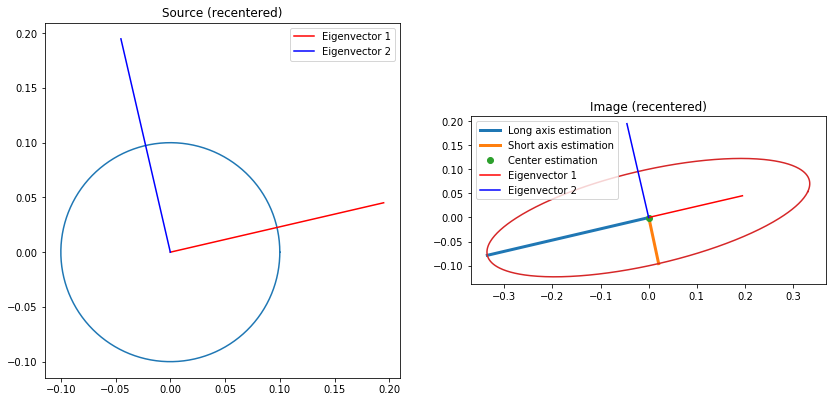

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.21837742115931763
 lambda2 = 0.9965808187086267
 1/lambda1 = 4.579227992945517
 1/lambda2 = 1.0034309122021874
 gamma 0.38910169877465456
 kappa 0.39252088006602776
 g  0.6405186384298223
 g1 0.480485321259689
 g2 -0.4235539897462504

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.6424302893768638
 g1 0.47927433864323254
 g2 -0.42779993574909864

Estimate based on g = (1+b/a)/(1-b/a)
 g  1.5565891218640502
 g1 1.1612671977908615
 g2 -1.036546279545904



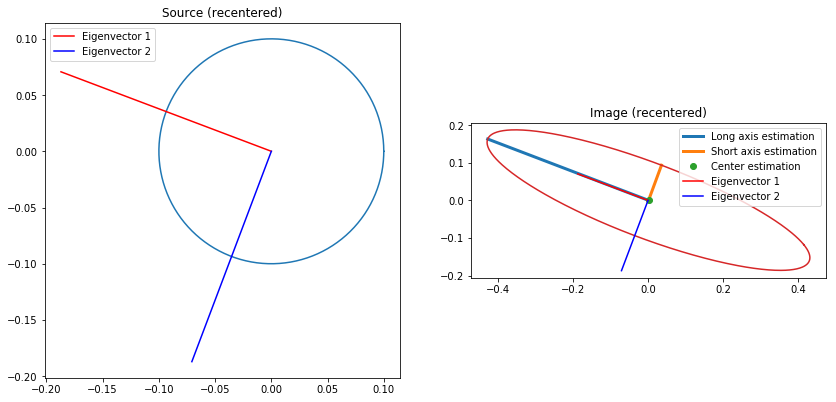

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = -0.4150805657977462
 lambda2 = 0.7363776916654424
 1/lambda1 = -2.4091708511529397
 1/lambda2 = 1.3579987706286039
 gamma 0.5757291287315943
 kappa 0.8393514370661519
 g  3.5837801360767116
 g1 -1.3053281727151989
 g2 -3.3376036950563823

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.2829718945844785
 g1 -0.10506845717289773
 g2 -0.2627426734126685

Estimate based on g = (1+b/a)/(1-b/a)
 g  3.5339198667359515
 g1 -1.3121568441128337
 g2 -3.2812854250977455



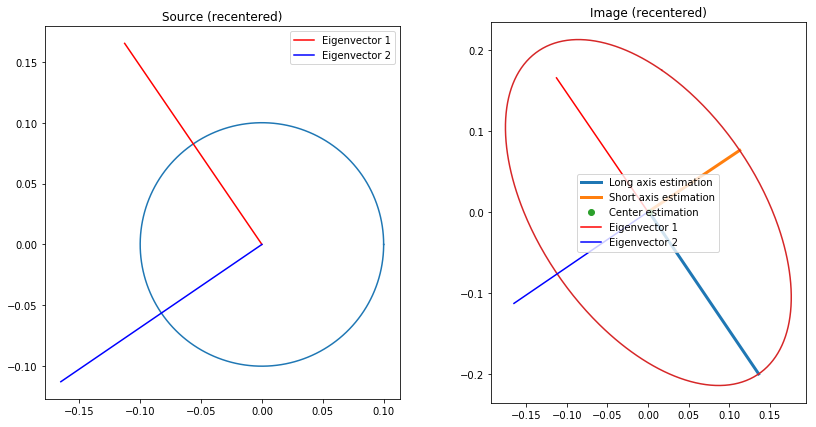

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.40392233104898695
 lambda2 = 1.094655235488653
 1/lambda1 = 2.475723482291752
 1/lambda2 = 0.9135296370766464
 gamma 0.34536645221983303
 kappa 0.25071121673118
 g  0.460925693713377
 g1 -0.13368078865785052
 g2 -0.44111443171695586

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.46247212622652
 g1 -0.13575750109110138
 g2 -0.44209769105252955

Estimate based on g = (1+b/a)/(1-b/a)
 g  2.162292478379978
 g1 -0.6347353858666283
 g2 -2.0670316282019905



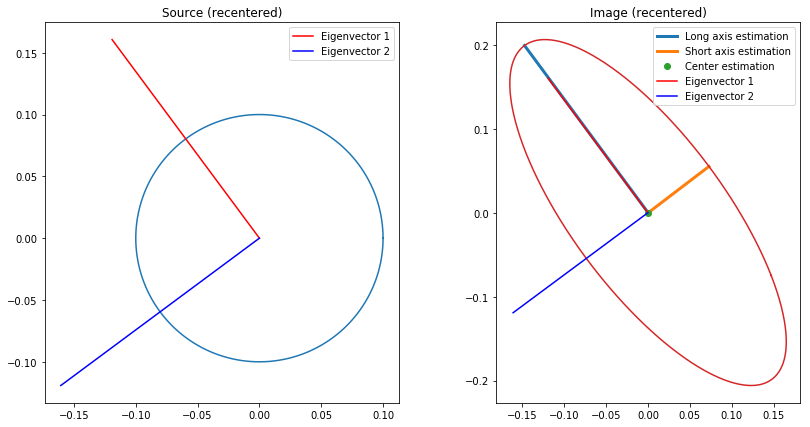

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.09295751977843608
 lambda2 = 1.0496114210168936
 1/lambda1 = 10.75760199264671
 1/lambda2 = 0.9527335354555987
 gamma 0.47832695061922875
 kappa 0.42871552960233517
 g  0.8372833070121276
 g1 -0.8372467819313888
 g2 -0.0078206359522934

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.8425959727897966
 g1 -0.8425953755949489
 g2 -0.0010031887114441227

Estimate based on g = (1+b/a)/(1-b/a)
 g  1.1868084257381932
 g1 -1.1868075845807464
 g2 -0.0014130055848775634



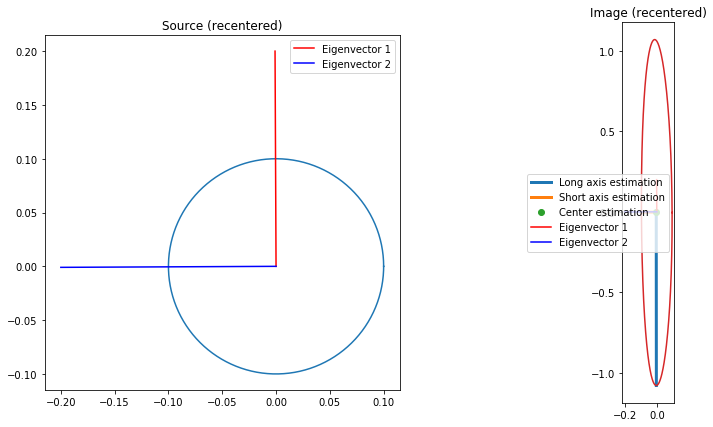

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = -4.893877230416766
 lambda2 = -3.55391296092619
 1/lambda1 = -0.20433696084256678
 1/lambda2 = -0.2813799918553404
 gamma 0.6699821347452882
 kappa 5.2238950956714785
 g  0.15861713408362482
 g1 0.0011303919474098668
 g2 -0.15861310613864116

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.15973949423231149
 g1 0.0003873895345349082
 g2 -0.1597390244960298

Estimate based on g = (1+b/a)/(1-b/a)
 g  6.260192601747476
 g1 0.015181800278914895
 g2 -6.260174192777236



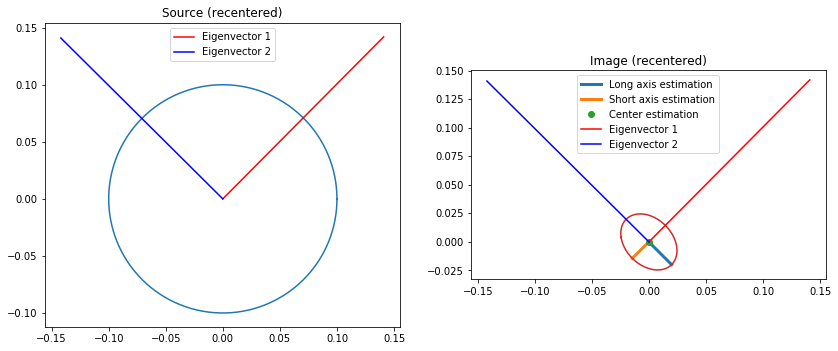

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.2714081795709293
 lambda2 = 1.0880314593561118
 1/lambda1 = 3.6844873340991624
 1/lambda2 = 0.919091071678931
 gamma 0.4083116398925913
 kappa 0.32028018053647944
 g  0.6007058028922234
 g1 -0.5673888645027789
 g2 -0.19727477808031596

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.6028115142067206
 g1 -0.56956492156578
 g2 -0.19742725693775492

Estimate based on g = (1+b/a)/(1-b/a)
 g  1.6588933297267319
 g1 -1.5674011311399527
 g2 -0.5433054145810076



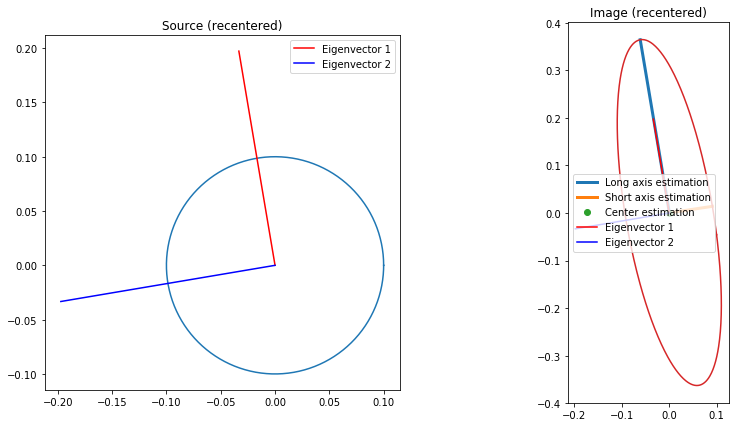

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.3314444885086723
 lambda2 = 1.053696593144068
 1/lambda1 = 3.0170964812221786
 1/lambda2 = 0.9490397961866369
 gamma 0.36112605231769784
 kappa 0.30742945917362985
 g  0.5214285491941439
 g1 0.2604311670958608
 g2 -0.4517337037678256

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.5230084247597484
 g1 0.26140069355871376
 g2 -0.45299833308379495

Estimate based on g = (1+b/a)/(1-b/a)
 g  1.9120150893541812
 g1 0.9556291003945117
 g2 -1.65607207705379



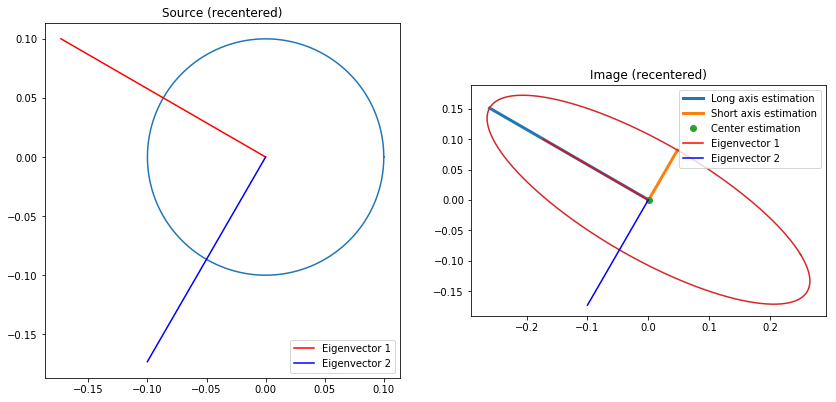

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.4466165944525359
 lambda2 = 1.0795409281662334
 1/lambda1 = 2.239056972851184
 1/lambda2 = 0.9263196733991865
 gamma 0.3164621668568487
 kappa 0.23692123869061538
 g  0.4147175663935711
 g1 0.29205389487917466
 g2 -0.2944404563936655

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.41549109526409955
 g1 0.29251611314173
 g2 -0.2950714723524042

Estimate based on g = (1+b/a)/(1-b/a)
 g  2.406790449659018
 g1 1.6944406161903218
 g2 -1.7092428928547343



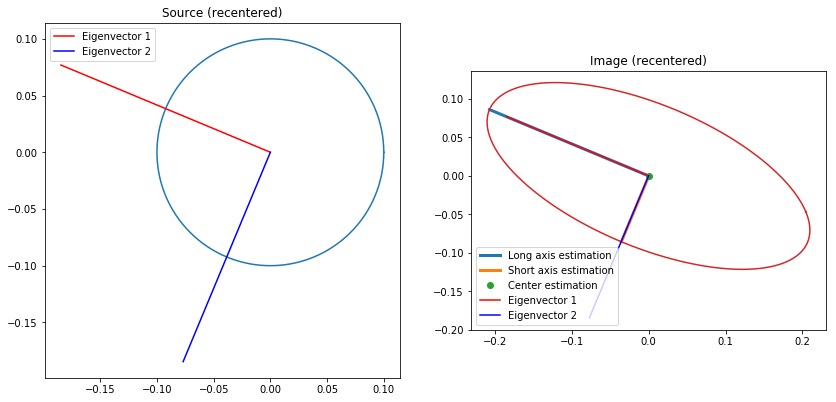

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.446166302058209
 lambda2 = 1.0991887337064794
 1/lambda1 = 2.2413167363534665
 1/lambda2 = 0.9097618719471281
 gamma 0.32651121582413517
 kappa 0.22732248211765582
 g  0.4225711351340924
 g1 0.34573452725393633
 g2 -0.24296913572100579

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.42343407272618444
 g1 0.3462696897490697
 g2 -0.24370825982425523

Estimate based on g = (1+b/a)/(1-b/a)
 g  2.3616427312089607
 g1 1.9312694667410104
 g2 -1.3592478201954248



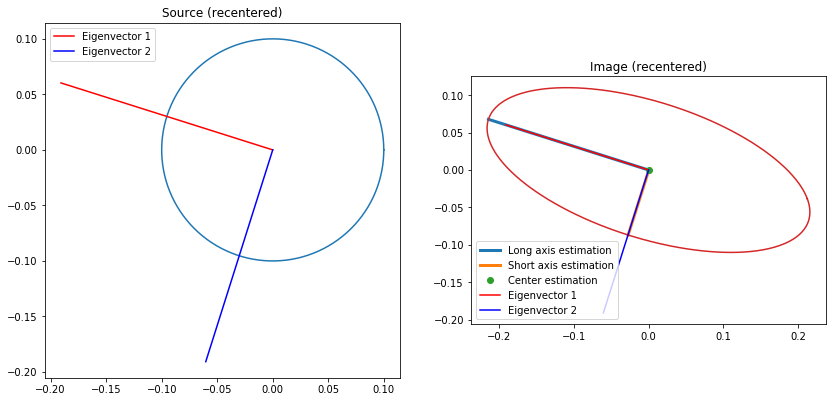

In [32]:
for i in range(10):
    print("-----------------------------------------------------------------------------------------------")
    plt.figure(figsize=(14,7))
    estimateReducedShearFromDeformedCircularSource()
    plt.show()

In [26]:
def estGFromEll(noiseLevel=0, simulateMeasurement = False):
    theta = np.random.uniform(-100*ANGLE_ARCSEC, 100*ANGLE_ARCSEC, 2)
    zs = 2
    kappa, gamma, gamma1, gamma2, lambda1, lambda2, v1, v2 = getWeakLensingProperties(lens, theta, zs, 1)

    if not simulateMeasurement:
        g = gamma/(1-kappa)
        a = 1/(1-kappa-gamma)
        b = 1/(1-kappa+gamma)
    else:
        g = abs(gamma/(1-kappa))
        a = abs(1/(1-kappa-gamma))
        b = abs(1/(1-kappa+gamma))

    a *= np.random.normal(1, noiseLevel)
    b *= np.random.normal(1, noiseLevel)

    if simulateMeasurement:
        if a < b:
            a, b = b, a

    aOverB = a/b
    gEst = (aOverB-1)/(aOverB+1)
    return kappa, g, gEst, abs(g-gEst)

def plotNPHist(h, *args, **kwargs):
    counts, edges = h
    if False:
        binWidth = edges[1]-edges[0]
        center = (edges[:-1] + edges[1:])/2
        plt.bar(center, counts, *args, align='center', width=binWidth, **kwargs)
    else:
        y = np.array([counts,counts]).T.reshape((-1,))
        x = np.array([edges, edges]).T.reshape((-1,))[1:-1]
        plt.plot(x, y, *args, **kwargs)

def plotNoiseSensitivity(noiseLevel, numPts, gDiffThreshold, simulateMeasurement=False, *args, **kwargs):
    a = np.array([ estGFromEll(noiseLevel, simulateMeasurement=simulateMeasurement) for i in range(numPts) ])
    correctBelowThreshold = a[a[:,3] < gDiffThreshold][:,0]
    total = a[:,0]
    
    kappaRange = [0.1, 3]
    numBins = 100
    corrCount = np.histogram(correctBelowThreshold, bins=numBins, range=kappaRange)
    totalCount = np.histogram(total, bins=numBins, range=kappaRange)
    frac = corrCount[0]/totalCount[0], corrCount[1]
    plotNPHist(frac, *args, **kwargs)
    plt.gca().set_xlim(kappaRange)


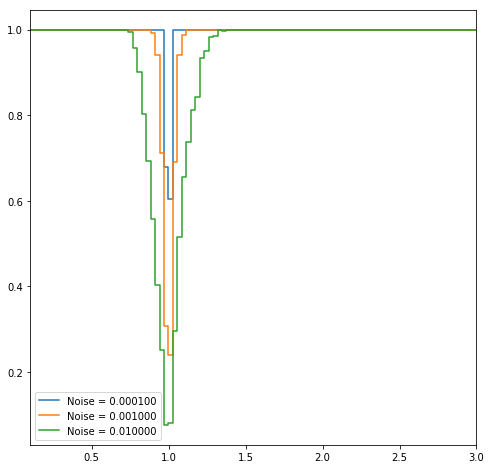

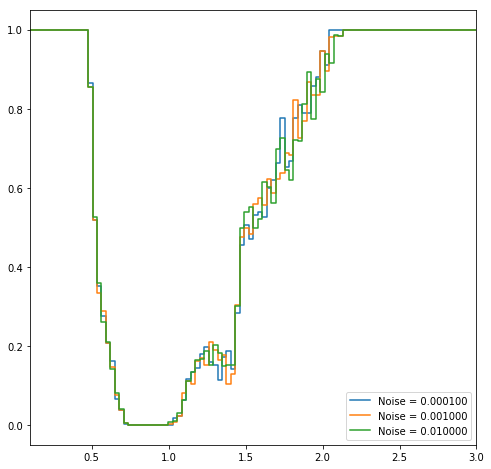

In [28]:
numPoints = 100000
gErrorTolerance = 0.1
baseNoise = 0.0001
for simulateMeasurement in [ False, True]:
    plt.figure(figsize=(8,8))
    for i in range(3):
        noise = baseNoise*10**i
        plotNoiseSensitivity(noise, numPoints, gErrorTolerance, simulateMeasurement, label =f"Noise = {noise:05f}")
    plt.legend()

In [6]:
# Derivations for these formulas can be found at
# https://nbviewer.jupyter.org/url/research.edm.uhasselt.be/~jori/grale2/_static/ellipsetransform.ipynb

def getTransFormedEllipseParams(a, b, theta, kappa, gamma1, gamma2):
    
    A = 1-kappa-gamma1
    B = -gamma2
    C = 1-kappa+gamma1
    
    sin = np.sin
    cos = np.cos
    sqrt = np.sqrt
    
    C_x = (A*sin(theta) + B*cos(theta))**2/b**2 + (A*cos(theta) - B*sin(theta))**2/a**2
    C_y = (B*sin(theta) + C*cos(theta))**2/b**2 + (B*cos(theta) - C*sin(theta))**2/a**2
    C_xy = 2*(a**2*(A*sin(theta) + B*cos(theta))*(B*sin(theta) + C*cos(theta)) + b**2*(A*cos(theta) - B*sin(theta))*(B*cos(theta) - C*sin(theta)))/(a**2*b**2)
    
    a_new = sqrt(2/((C_x+C_y)-sqrt(C_xy**2+(C_x-C_y)**2)))
    b_new = sqrt(2/((C_x+C_y)+sqrt(C_xy**2+(C_x-C_y)**2)))
    
    #cosTwoTheta_new = -(C_x-C_y)*(a_new**2*b_new**2)/(a_new**2-b_new**2)
    cosTwoTheta_new = -(C_x-C_y)*(b_new**2)/(1-(b_new/a_new)**2)
    sinTwoTheta_new = C_xy*(C_x+C_y)/(1/b_new**4-1/a_new**4)
    theta_new = 0.5*np.arctan2(sinTwoTheta_new, cosTwoTheta_new)
    
    return a_new, b_new, theta_new
    

In [7]:
def plotEllipse(a, b, theta):
    angles = np.linspace(0, np.pi*2, 20)
    x = a*np.cos(angles)
    y = b*np.sin(angles)
    xy = np.array([x,y])
    rotAngle = theta
    rotMatrix = np.array([[ np.cos(rotAngle), np.sin(rotAngle)],[-np.sin(rotAngle), np.cos(rotAngle)]])
    xyRot = rotMatrix.dot(xy).T
    plt.plot(xyRot[:,0], xyRot[:,1], 'o')

In [4]:
def generateBetaEllipseAndTrace(beta, betaRadius, betaE, betaAngle, numPts):
    angles = np.linspace(0, np.pi*2, numPts)
    betas = np.zeros((numPts,2))

    x = betaRadius*np.cos(angles)
    y = betaRadius*betaE*np.sin(angles)
    xy = np.array([x,y])
    
    rotAngle = betaAngle
    rotMatrix = np.array([[ np.cos(rotAngle), np.sin(rotAngle)],[-np.sin(rotAngle), np.cos(rotAngle)]])
    xyRot = rotMatrix.dot(xy)
    betas[:,0] = xyRot[0,:] + beta[0]
    betas[:,1] = xyRot[1,:] + beta[1]
    ip = li.getImagePlane()
    thetas = np.array([ ip.traceBeta(i)[0] for i in betas ])
    return betas, thetas

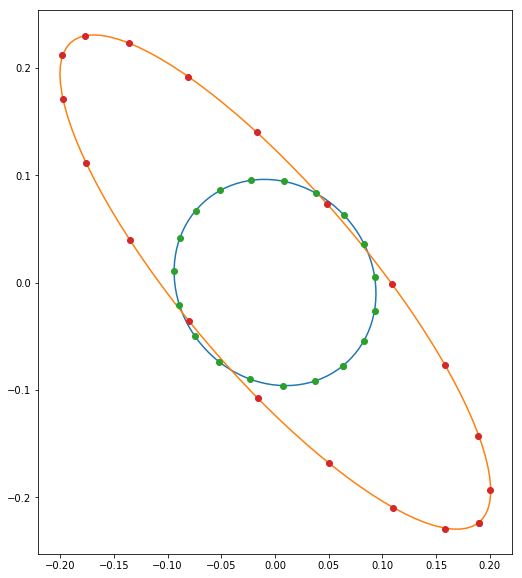

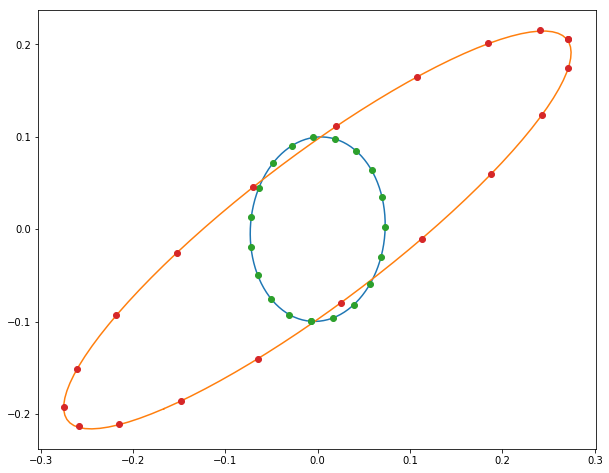

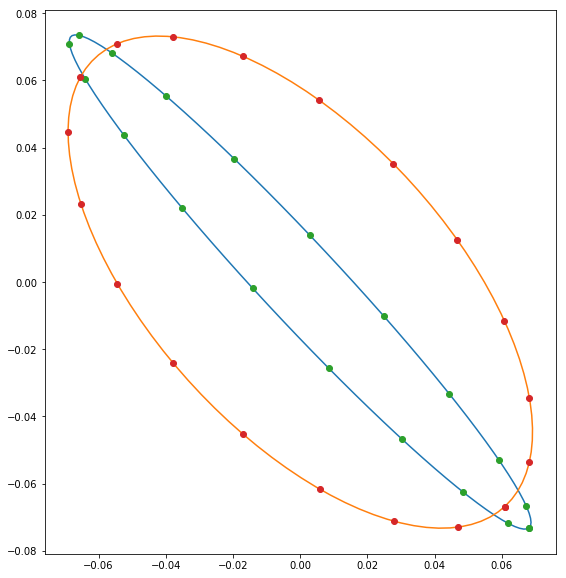

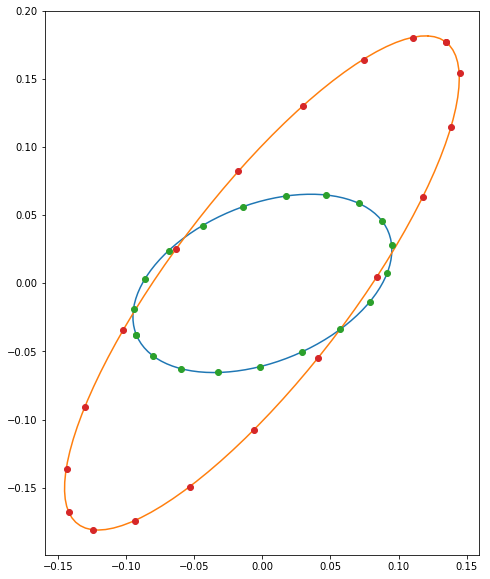

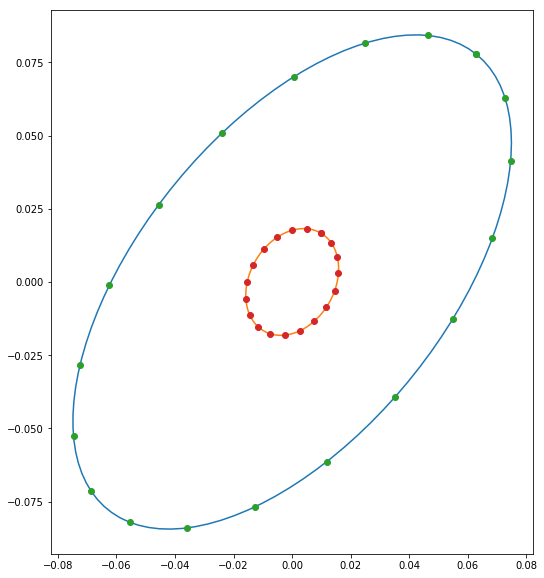

In [8]:
def getTransFormedRandomEllipseParams(plot=False, beta=None, theta=None, zs=None, betaE=None):
    beta, theta, zs = pickBetaTheta(beta, theta, zs)
    #print(beta, theta, zs)
    kappa, gamma, gamma1, gamma2, lambda1, lambda2, v1, v2 = getWeakLensingProperties(lens, theta, zs)
    
    betaRadius = 0.1
    betaE = np.random.uniform(0.1,0.9) if betaE is None else betaE
    betaAngle = np.random.uniform(0,2*np.pi)
    
    if plot:
        betas, thetas = generateBetaEllipseAndTrace(beta, betaRadius*ANGLE_ARCSEC, betaE, betaAngle, 100)
        betas = (betas-beta)/ANGLE_ARCSEC
        thetas = (thetas-theta)/ANGLE_ARCSEC

        #plt.figure(figsize=(10,10))
        plt.plot(betas[:,0],betas[:,1])
        plt.plot(thetas[:,0],thetas[:,1])
        plt.gca().set_aspect("equal")

    a_new, b_new, theta_new = getTransFormedEllipseParams(betaRadius, betaRadius*betaE, betaAngle, kappa, gamma1, gamma2)
    if plot:    
        plotEllipse(betaRadius, betaRadius*betaE, betaAngle)
        plotEllipse(a_new, b_new, theta_new)

    return betaRadius, betaRadius*betaE, betaAngle, a_new, b_new, theta_new

for i in range(5):
    plt.figure(figsize=(10,10))
    getTransFormedRandomEllipseParams(True)

In [24]:
def getRealAndEstimatedShearFromEllipses(kappaThresholdFunction, num, betaE=None, noiseLevel=0):
    while True:
        beta, theta, zs = pickBetaTheta()
        kappa, gamma, gamma1, gamma2, lambda1, lambda2, v1, v2 = getWeakLensingProperties(lens, theta, zs)
        if kappaThresholdFunction(kappa): 
            break

    g1Ests = [ ]
    g2Ests = [ ]
    for i in range(num):
        a_orig, b_orig, theta_orig, a_new, b_new, theta_new = getTransFormedRandomEllipseParams(False, beta, theta, zs,
                                                                                                betaE=betaE)
        theta_new = -theta_new # Apparently I used a different angle orientation here
        a_new *= np.random.normal(1, noiseLevel)
        b_new *= np.random.normal(1, noiseLevel)

        aOverB = a_new/b_new
        gEst = (aOverB-1)/(aOverB+1)
        g1Est = gEst*np.cos(2*theta_new)
        g2Est = gEst*np.sin(2*theta_new)

        g1Ests.append(g1Est)
        g2Ests.append(g2Est)

    return kappa, gamma1, gamma2, g1Ests, g2Ests

kappa, gamma1, gamma2, g1Ests, g2Ests = getRealAndEstimatedShearFromEllipses(lambda kappa: abs(1-kappa) > 0.5, 
                                                                             50, betaE=None, noiseLevel=0.01)
print("kappa =", kappa)
print("g1,real = ", gamma1/(1-kappa))
print("g2,real = ", gamma2/(1-kappa))
print("g1Est,mean =", np.mean(g1Ests))
print("g2Est,mean =", np.mean(g2Ests))

kappa = 0.3632332895989485
g1,real =  -0.2277621415771403
g2,real =  0.7110582397651407
g1Est,mean = -0.2224769590542559
g2Est,mean = 0.6934874264723321


In [44]:
def getEstimatedShearDeviations(kappaThresholdFunction, numEllipses, numRepeats, noiseLevel=0):
    g1Diffs, g2Diffs = [], []
    for i in range(numRepeats):
        kappa, gamma1, gamma2, g1Ests, g2Ests = getRealAndEstimatedShearFromEllipses(kappaThresholdFunction, 
                                                                             numEllipses, 
                                                                             betaE=None, noiseLevel=noiseLevel)
        g1Est, g2Est = np.mean(g1Ests), np.mean(g2Ests)
        g1Diffs.append(gamma1/(1-kappa) - g1Est)
        g2Diffs.append(gamma2/(1-kappa) - g2Est)
    
    return g1Diffs, g2Diffs

In [63]:
numEllipses = [ 1, 5, 10, 25, 50, 100, 200 ]
precisions = [ ]
for n in numEllipses:
    p = np.std(g1Diffs+g2Diffs)
    precisions.append(p)
    print(n, p)    

1 0.2353622251985153
5 0.11527298745307345
10 0.08706137191998924
25 0.05946975673619648
50 0.06455144692570643
100 0.07738349123259894
200 0.0632429223484918


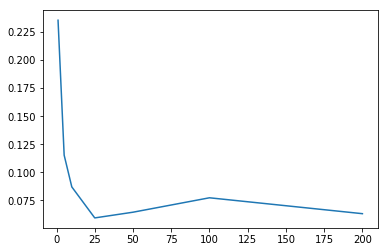

In [64]:
plt.plot(numEllipses, precisions)